# 04 - Question answering using Retrieval Augmented Generation
In this notebook we will be using the output of the `document_processing.ipynb` notebook to answer questions using retrieval augmented generation.

Notebook overview:
1. Load the PDFs as plaintext (output of `document_processing.ipynb`).
2. Chunk the plaintext into a reasonable size, such that the LLMs context window can fit multiple chunks.
3. Embed each of the chunks using an LLM and store the embeddings in a vector store.
4. Answer a user question using the embeddings.

### Setup

In [1]:
import botocore
import boto3
from botocore.config import Config

In [2]:
boto3.__version__, botocore.__version__

('1.28.64', '1.31.64')

In [3]:
ssm_client = boto3.client("ssm")

In [20]:
bedrock_region_parameter = "/AgenticLLMAssistant/bedrock_region"
bedrock_endpoint_parameter = "/AgenticLLMAssistant/bedrock_endpoint"
s3_bucket_name_parameter = "/AgenticLLMAssistant/AgentDataBucketParameter"

BEDROCK_REGION = ssm_client.get_parameter(Name=bedrock_region_parameter)
BEDROCK_REGION = BEDROCK_REGION["Parameter"]["Value"]

S3_BUCKET_NAME = ssm_client.get_parameter(Name=s3_bucket_name_parameter)
S3_BUCKET_NAME = S3_BUCKET_NAME["Parameter"]["Value"]

BEDROCK_REGION, S3_BUCKET_NAME

('us-west-2', 's3://demoexperimentdata2/')

In [7]:
# LLM_MODEL_ID = "anthropic.claude-v1"
LLM_MODEL_ID = "anthropic.claude-v2"

In [8]:
retry_config = Config(
    region_name=BEDROCK_REGION, retries={"max_attempts": 10, "mode": "standard"}
)
bedrock_runtime = boto3.client("bedrock-runtime", config=retry_config)

In [9]:
bedrock_client = boto3.client("bedrock", config=retry_config)
bedrock_client.list_foundation_models()

{'ResponseMetadata': {'RequestId': 'ff57d2ef-44c5-4070-b3a1-695866d81f8f',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Sat, 24 Feb 2024 11:12:42 GMT',
   'content-type': 'application/json',
   'content-length': '17086',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'ff57d2ef-44c5-4070-b3a1-695866d81f8f'},
  'RetryAttempts': 0},
 'modelSummaries': [{'modelArn': 'arn:aws:bedrock:us-west-2::foundation-model/amazon.titan-tg1-large',
   'modelId': 'amazon.titan-tg1-large',
   'modelName': 'Titan Text Large',
   'providerName': 'Amazon',
   'inputModalities': ['TEXT'],
   'outputModalities': ['TEXT'],
   'responseStreamingSupported': True,
   'customizationsSupported': [],
   'inferenceTypesSupported': ['ON_DEMAND']},
  {'modelArn': 'arn:aws:bedrock:us-west-2::foundation-model/amazon.titan-embed-g1-text-02',
   'modelId': 'amazon.titan-embed-g1-text-02',
   'modelName': 'Titan Text Embeddings v2',
   'providerName': 'Amazon',
   'inputModalities': ['TEXT'],
   'outputModaliti

### Load the PDFs as plaintext

In [11]:
from utils.helpers import load_list_from_s3

In [27]:
S3_BUCKET_NAME = 'demoexperimentdata2'
print(S3_BUCKET_NAME)

demoexperimentdata2


In [28]:
documents_processed = load_list_from_s3(S3_BUCKET_NAME, "documents_processed.json")

In [29]:
len(documents_processed)

2

We will be using Langchains vectorstores to store the embeddings, therefore, we will convert the documents to Langchain Document objects.

In [34]:
import json
from langchain.schema.document import Document

langchain_documents_text = []
langchain_documents_tables = []

for document in documents_processed:
    document_name = document["name"]
    document_source_location = document["source_location"]
    document_s3_metadata = document["metadata"]
    print(document_s3_metadata)
    # mapping_to_original_page_numbers = {
    #     idx: pg_num
    #     for idx, pg_num in enumerate(json.loads(document_s3_metadata["pages_kept"]))
    # }
    # remove pages_kept since we already put the original page number.
    # del document_s3_metadata["pages_kept"]

    for page in document["pages"]:
        # Turn each page into a Langchain Document.
        # Note: you could choose to also prepend part of the previous document
        # and append part of the next document to include more context for documents
        # that have many pages which continue their text on the next page.
        current_metadata = {
            "document_name": document_name,
            "document_source_location": document_source_location,
            "page_number": page["page"],
            # "original_page_number": mapping_to_original_page_numbers[page["page"]],
        }
        # merge the document_s3_metadata into the langchain Document metadata
        # to be able to use them for filtering.
        current_metadata.update(document_s3_metadata)

        langchain_documents_text.append(
            Document(page_content=page["page_text"], metadata=current_metadata)
        )

        # Turn all the tables of the pages into seperate Langchain Documents as well
        for table_markdown in page["page_tables"]:
            langchain_documents_tables.append(
                Document(page_content=table_markdown, metadata=current_metadata)
            )

{}
{}


In [35]:
print(
    f"Your documents contain {len(langchain_documents_text)}"
    f" pages and {len(langchain_documents_tables)} tables combined"
)

Your documents contain 32 pages and 29 tables combined


In [36]:
len(langchain_documents_text), len(langchain_documents_tables)

(32, 29)

In [37]:
chunk_lengths = [len(doc.page_content) for doc in langchain_documents_text]

print(
    f"Number of chunks: {len(chunk_lengths)},"
    f" Max chunk length {max(chunk_lengths)},"
    f" Min chunk length: {min(chunk_lengths)}"
)

Number of chunks: 32, Max chunk length 3047, Min chunk length: 120


In [39]:
%pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.


Plot the distribution of the length of the smaller chunks, to determine if some of them should be removed

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_chunks_length_distribution(chunks, bin_size=50):
    chunk_lengths = [len(doc.page_content) for doc in chunks]
    bin_size = 50
    num_bins = (max(chunk_lengths) - min(chunk_lengths)) // bin_size + 1

    # Display smoothed histogram using seaborn
    sns.histplot(chunk_lengths, kde=True, bins=num_bins, edgecolor="black")
    plt.xlabel("Chunk Length")
    plt.ylabel("Frequency")
    plt.title("Distribution of Chunk Lengths")
    plt.show()

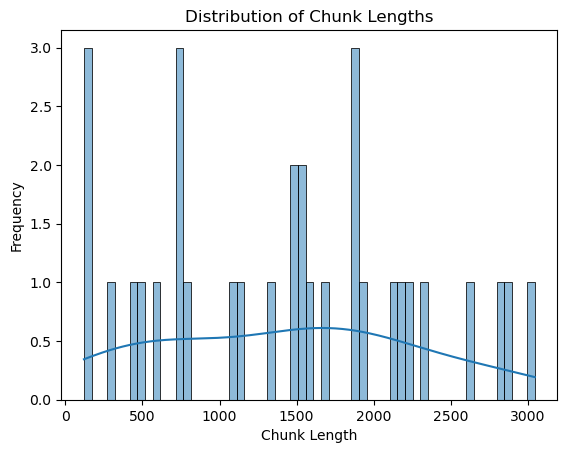

In [41]:
plot_chunks_length_distribution(langchain_documents_text, bin_size=50)

### Chunk the Documents containing page text and tables

In [42]:
%pip install tiktoken --quiet

Note: you may need to restart the kernel to use updated packages.


In [43]:
from langchain.text_splitter import TokenTextSplitter

# The chunk overlap duplicates some text across chunks to prevent context from being lost between chunks.
# TODO: the following spliting uses tiktoken, create a custom one that use the tokenizer from anthropic.
text_splitter = TokenTextSplitter(chunk_size=512, chunk_overlap=64)

In [44]:
langchain_documents_text_chunked = text_splitter.split_documents(
    langchain_documents_text + langchain_documents_tables
)

In [45]:
len(langchain_documents_text_chunked)

190

Due to splitting of the chunks, we may have created some small chunks that are already captured in the chunk overlap.<br>
It is recommended to have a look and estimate until which chunk length, the chunks can be removed.<br>
The reason for this is that semantic search can occasionally favor chunks containing very little content.

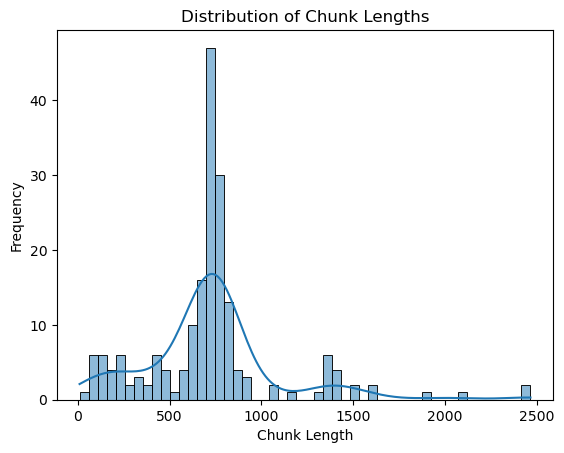

In [46]:
plot_chunks_length_distribution(langchain_documents_text_chunked, bin_size=50)

### Embed the documents and store them in a vector store

For the embedding model we use Amazon Titan embedding model available through Amazon Bedrock.

In [47]:
from langchain.embeddings import BedrockEmbeddings

from langchain.llms.bedrock import Bedrock as LangchainBedrock

# Define an embedding model to generate embeddings
# TODO: request access for other embedding models
embedding_model_id = "amazon.titan-embed-text-v1"
embedding_model = BedrockEmbeddings(model_id=embedding_model_id, client=bedrock_runtime)

<div class="alert alert-block alert-warning">
Warning: The following lines of code create embedding for each document chunk and store them, this will use your embedding model for each document and incur costs.
</div>

TODO - implement the following improvements to the embedding generation process:

* Decorrelate embedding generation from `FAISS.from_documents`.
* Create the embedding independently and save them on S3, then update the code to attempt to load them from S3 before calling the embedding model.
* Create the index from the embeddings and text pair, without calling the embedding API.

In [48]:
len(langchain_documents_text_chunked)

190

You may see a "An error occurred (ResourceNotFoundException) when calling the InvokeModel operation: Could not resolve the foundation model from the provided model identifier." error when trying to run the following cell. If this happens then you should visit the "Bedrock" service in your AWS account and request for access to the models in the "Model access" section

In [49]:
%%time
from langchain.vectorstores import FAISS

faiss = FAISS.from_documents(langchain_documents_text_chunked, embedding_model)

CPU times: user 755 ms, sys: 37 ms, total: 792 ms
Wall time: 48.6 s


In [50]:
faiss.save_local("faiss_vector_store")

### Answer questions using RAG

In [80]:
from langchain.chains import ConversationChain, LLMChain
from langchain.memory import ConversationBufferMemory
from langchain.prompts.prompt import PromptTemplate

# Define a custom template for structured data extraction
template = """\n\nHuman:
The following is a friendly conversation between a human and an AI assistant.
The assistant is helpful and answers questions about documents based on extracts of those documents available within the <context></context> XML tags.
When answering, the assistant abides by the rules defined in the <rules></rules> XML tags.

The rules are below:
<rules>
The assistant answers the human questions accurately and concisely.
When answering, the assistant relies on the context available in the <context></context> XML tags below.
The assistant considers the conversation history available in the <history></history> XML tags when answering.
If the assistant does not know the answer to a question, it truthfully says it does not know.
The assistant answers in Markdown and puts the answer inside <response></response> XML tags.
</rules>

The retrieved document chuncks that the AI assistant uses to respond are below within the <context></context> XML tags, each document chunk is within a <document></document> XML tags:
<context>
{context}
</context>

Current conversation:
<history>
{history}
</history>

The user input to respond to is within the input XML tags below:
<input>
{input}
</input>
\n\nAssistant: """

PROMPT = PromptTemplate(
    input_variables=["history", "input", "context"], template=template
)

claude_llm = LangchainBedrock(
    model_id=LLM_MODEL_ID,
    client=bedrock_runtime,
    model_kwargs={"max_tokens_to_sample": 512, "temperature": 0.0},
)

conversation = LLMChain(
    llm=claude_llm,
    memory=ConversationBufferMemory(input_key="input"),
    prompt=PROMPT,
    verbose=True,
)

In [81]:
def combine_documents(retrieved_documents):
    combined_documents = ""
    # Add each of the extracts to the query
    for idx, extract in enumerate(retrieved_documents):
        combined_documents += f"<document>{extract.page_content}</document>\n"

    return combined_documents

In [99]:
%%time
# query = "can you tell me what was EXISTING FIS IMPROVEMENTS cost magnitude?"
# query = "what about the cost of the total FY 2024 Recommended Capital Improvement Program?"
query = 'can you summarize the project SECURITY SCREENING CHECKPOINT EXPANSION PROJECT?'
k = 4
retrieved_chuncks = faiss.similarity_search(query=query, k=k)

CPU times: user 4.99 ms, sys: 0 ns, total: 4.99 ms
Wall time: 338 ms


In [100]:
%%time
response = conversation.predict(
    input=query, context=combine_documents(retrieved_chuncks)
)



> Entering new LLMChain chain...
Prompt after formatting:


Human:
The following is a friendly conversation between a human and an AI assistant.
The assistant is helpful and answers questions about documents based on extracts of those documents available within the <context></context> XML tags.
When answering, the assistant abides by the rules defined in the <rules></rules> XML tags.

The rules are below:
<rules>
The assistant answers the human questions accurately and concisely.
When answering, the assistant relies on the context available in the <context></context> XML tags below.
The assistant considers the conversation history available in the <history></history> XML tags when answering.
If the assistant does not know the answer to a question, it truthfully says it does not know.
The assistant answers in Markdown and puts the answer inside <response></response> XML tags.
</rules>

The retrieved document chuncks that the AI assistant uses to respond are below within the <context><

/opt/conda/lib/python3.10/site-packages/langchain/llms/bedrock.py:50: UserWarning: Error: Prompt must alternate between '

Human:' and '

Assistant:'. Received 

Human:
The following is a friendly conversation between a human and an AI assistant.
The assistant is helpful and answers questions about documents based on extracts of those documents available within the <context></context> XML tags.
When answering, the assistant abides by the rules defined in the <rules></rules> XML tags.

The rules are below:
<rules>
The assistant answers the human questions accurately and concisely.
When answering, the assistant relies on the context available in the <context></context> XML tags below.
The assistant considers the conversation history available in the <history></history> XML tags when answering.
If the assistant does not know the answer to a question, it truthfully says it does not know.
The assistant answers in Markdown and puts the answer inside <response></response> XML tags.
</rules>




> Finished chain.
CPU times: user 13.5 ms, sys: 232 µs, total: 13.7 ms
Wall time: 13.3 s


In [101]:
response = response.strip().strip("<response>").strip("</response>").strip()

In [102]:
print(response)

Based on the information provided in Document 1, here is a summary of the Security Screening Checkpoint Expansion Project:

- Duration: Not specified
- Previously approved for $3,085,000 in FY2023 capital budget
- Additional funding request of $8,255,000 made for a total estimated project budget of $11,340,000
- Scope includes adding screening lanes at Terminal 2 and 4 checkpoints by relocating exit corridors
- Also includes relocating manager's stations, adding CAT scanners, CCTV and other systems, renovating breakrooms, and adding advertising infrastructure in exit corridors to generate revenue
- Project aims to reduce wait times at security checkpoints and accommodate increasing passenger volumes


In [89]:
from IPython.display import display, Markdown

display(Markdown(response))

Here is a summary of the main projects mentioned in the documents, along with their durations and cost magnitudes:

- New Airport Beacon (Duration: 3 months, Cost: $250,000)
- Terminal 2 and 4 Curb Improvements (Duration: 1 year, Cost: $2,000,000)  
- Existing FIS Improvements (Duration: 2 years, Cost: $10,000,000)
- Advertising Display Replacement (Duration: 3 months, Cost: $500,000)
- Global Entry Enrollment Center (Duration: 3 months, Cost: Not specified)
- Tenant Metering within Terminal Building (Duration: 6 months, Cost: $300,000)  
- Permanent Bus Charging Station and Parking (Duration: 2 years, Cost: $4,500,000)
- Police Terminal Offices (Duration: 1 year, Cost: $250,000)
- Terminals 2 and 4 Fire Alarm System Replacement (Duration: 1 month, Cost: Not specified)
- South Security Airport Access Point (Duration: 1 year, Cost: Not specified)
- OIAA Fleet Vehicles (Duration: 1 year, Cost: Not specified)
- Server Room Relocation (Duration: 1 year, Cost: Not specified)
- Water Consumption Reduction (Duration: 2.5 years, Cost: $3,250,000)
- Administration Office Reconfiguration (Duration: Not specified, Cost: Not specified)
- Security Screening Checkpoint Expansion (Duration: Not specified, Cost: Not specified)

## Upload semantic search index to S3

In [ ]:
!aws s3 sync ./faiss_vector_store s3://{S3_BUCKET_NAME}/semantic_search_index/faiss_vector_store/